---

_You are currently looking at **version 1.2** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-social-network-analysis/resources/yPcBs) course resource._

---

# Network Modelling

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle

---

## Company Emails

For the second part of this assignment you will be workking with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagementSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagementSalary` indicates whether that person is receiving a management position salary.

In [3]:
G = nx.read_gpickle('email_prediction.txt')

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


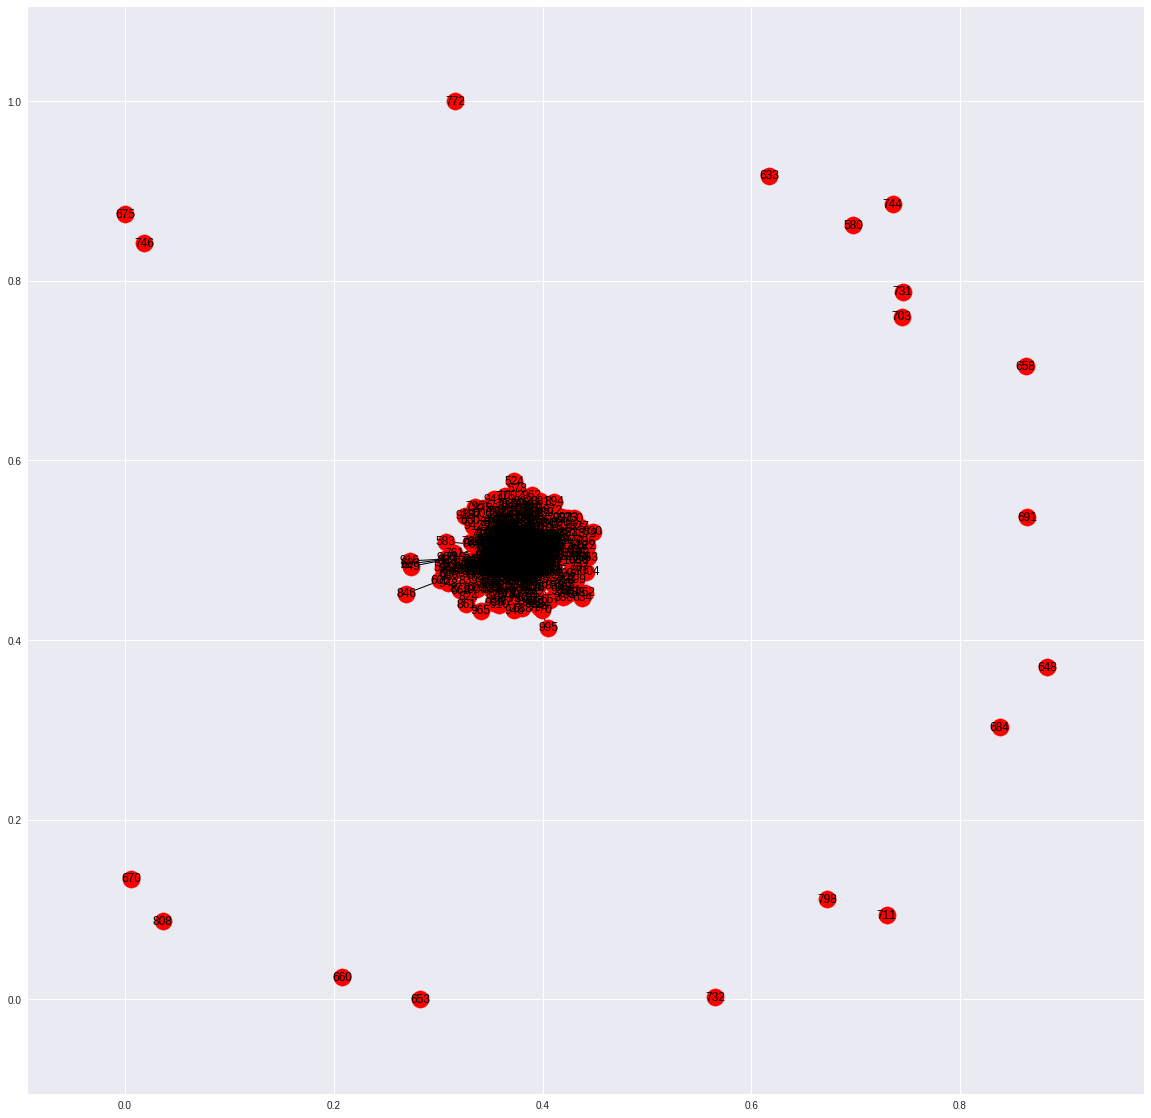

In [20]:
#%matplotlib inline
#import matplotlib.pyplot as plt
#plt.figure(figsize=(20,20))
#nx.draw_networkx(G)

### Part 2A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a management position salary.

To accomplish this, you will need to create a matrix of node features using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a management salary for nodes where `ManagementSalary` is missing.



Your predictions will need to be given as the probability that the corresponding employee is receiving a management position salary.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 252 with the data being the probability of receiving management salary, and the index being the node id.

    Example:
    
        1       1.0
        2       0.0
        5       0.8
        8       1.0
            ...
        996     0.7
        1000    0.5
        1001    0.0
        Length: 252, dtype: float64

In [13]:
#without dummy: AUC = 0.8334025183340252
#with dummy: AUC = 0.93081499930815

def salary_predictions():
    
    # Your Code Here
    import pandas as pd
    
    df = pd.DataFrame(index=G.nodes())
    df["Department"] = pd.Series(nx.get_node_attributes(G, 'Department'))
    df["ManagementSalary"] = pd.Series(nx.get_node_attributes(G, 'ManagementSalary'))
    df['clustering'] = pd.Series(nx.clustering(G))
    df['degree'] = pd.Series(G.degree())
    df_dummy = pd.get_dummies(df["Department"])
    df = df[["clustering","degree","ManagementSalary"]].merge(df_dummy,left_index=True,right_index=True)

    X_train = df[df["ManagementSalary"].isin([0.0,1.0])].drop("ManagementSalary",axis=1)
    y_train = df[df["ManagementSalary"].isin([0.0,1.0])]["ManagementSalary"]
    X_test = df[~df["ManagementSalary"].isin([0.0,1.0])].drop("ManagementSalary",axis=1)

    from sklearn.svm import SVC
    SVC_model = SVC(probability=True).fit(X_train, y_train)
    predictions = SVC_model.predict(X_test)
    probabilities = SVC_model.predict_proba(X_test)
    management_salary_probabilities = pd.Series([s[1] for s in probabilities],index=X_test.index)
    
    return management_salary_probabilities # Your Answer Here
#salary_predictions()

### Part 2B - New Connections Prediction

For the last part of this assignment, you will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [4]:
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10) #len: 488446

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


Using network `G` and `future_connections`, identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, you will need to create a matrix of features for the edges found in `future_connections` using networkx, train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data, and predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



Your predictions will need to be given as the probability of the corresponding edge being a future connection.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 122112 with the data being the probability of the edge being a future connection, and the index being the edge as represented by a tuple of nodes.

    Example:
    
        (107, 348)    0.35
        (542, 751)    0.40
        (20, 426)     0.55
        (50, 989)     0.35
                  ...
        (939, 940)    0.15
        (555, 905)    0.35
        (75, 101)     0.65
        Length: 122112, dtype: float64

In [5]:
# ### initialize X,y data ###
# 
# X = future_connections.copy()
# X["nodes_pair"] = X.index
# X["nodes_pair_str"] = X["nodes_pair"].apply(lambda s:",".join([str(s[0]),str(s[1])]))
# 
# ### features for X ###
# 
# #feature 1: common_neighbors
# X["common_neighbors"] = X["nodes_pair"].apply(lambda s:len(list(nx.common_neighbors(G,s[0],s[1]))))
# 
# #feature 2: jaccard_coefficient
# df_jc = pd.DataFrame(list(nx.jaccard_coefficient(G)))
# df_jc.columns = ["node1","node2","jaccard_coefficient"]
# df_jc["nodes_pair_str"] = df_jc["node1"].astype(str) + "," + df_jc["node2"].astype(str)
# df_jc = df_jc.drop(["node1","node2"],axis=1)
# X = X.merge(df_jc,on="nodes_pair_str")
# 
# #feature 3: resource allocation index
# df_rai = pd.DataFrame(list(nx.resource_allocation_index(G)))
# df_rai.columns = ["node1","node2","resource_allocation_index"]
# df_rai["nodes_pair_str"] = df_rai["node1"].astype(str) + "," + df_rai["node2"].astype(str)
# df_rai = df_rai.drop(["node1","node2"],axis=1)
# X = X.merge(df_rai,on="nodes_pair_str")
# 
# #feature 4: preferential attachment
# df_pa = pd.DataFrame(list(nx.preferential_attachment(G)))
# df_pa.columns = ["node1","node2","preferential_attachment"]
# df_pa["nodes_pair_str"] = df_pa["node1"].astype(str) + "," + df_pa["node2"].astype(str)
# df_pa = df_pa.drop(["node1","node2"],axis=1)
# X = X.merge(df_pa,on="nodes_pair_str")
# X = X.set_index("nodes_pair")
# X = X.drop("nodes_pair_str",axis=1)
# 
# X_train = X[X["Future Connection"].isin([0.0,1.0])].drop("Future Connection",axis=1)
# y_train = X[X["Future Connection"].isin([0.0,1.0])]["Future Connection"]
# X_test = X[~X["Future Connection"].isin([0.0,1.0])].drop("Future Connection",axis=1)
# 
# X_train.head()

,common_neighbors,jaccard_coefficient,resource_allocation_index,preferential_attachment
nodes_pair,,,,
"(6, 840)",9,0.073770,0.136721,2070
"(4, 197)",2,0.015504,0.008437,3552
"(620, 979)",0,0.000000,0.000000,28
"(519, 872)",2,0.060606,0.039726,299
"(382, 423)",0,0.000000,0.000000,205


In [12]:
#AUC: 0.9062896578122774

def new_connections_predictions():
    
    ### initialize X,y data ###

    X = future_connections.copy()
    X["nodes_pair"] = X.index
    X["nodes_pair_str"] = X["nodes_pair"].apply(lambda s:",".join([str(s[0]),str(s[1])]))

    ### features for X ###

    #feature 1: common_neighbors
    X["common_neighbors"] = X["nodes_pair"].apply(lambda s:len(list(nx.common_neighbors(G,s[0],s[1]))))

    #feature 2: jaccard_coefficient
    df_jc = pd.DataFrame(list(nx.jaccard_coefficient(G)))
    df_jc.columns = ["node1","node2","jaccard_coefficient"]
    df_jc["nodes_pair_str"] = df_jc["node1"].astype(str) + "," + df_jc["node2"].astype(str)
    df_jc = df_jc.drop(["node1","node2"],axis=1)
    X = X.merge(df_jc,on="nodes_pair_str")

    #feature 3: resource allocation index
    df_rai = pd.DataFrame(list(nx.resource_allocation_index(G)))
    df_rai.columns = ["node1","node2","resource_allocation_index"]
    df_rai["nodes_pair_str"] = df_rai["node1"].astype(str) + "," + df_rai["node2"].astype(str)
    df_rai = df_rai.drop(["node1","node2"],axis=1)
    X = X.merge(df_rai,on="nodes_pair_str")

    #feature 4: preferential attachment
    df_pa = pd.DataFrame(list(nx.preferential_attachment(G)))
    df_pa.columns = ["node1","node2","preferential_attachment"]
    df_pa["nodes_pair_str"] = df_pa["node1"].astype(str) + "," + df_pa["node2"].astype(str)
    df_pa = df_pa.drop(["node1","node2"],axis=1)
    X = X.merge(df_pa,on="nodes_pair_str")
    X = X.set_index("nodes_pair")
    X = X.drop("nodes_pair_str",axis=1)

    X_train = X[X["Future Connection"].isin([0.0,1.0])].drop("Future Connection",axis=1)
    y_train = X[X["Future Connection"].isin([0.0,1.0])]["Future Connection"]
    X_test = X[~X["Future Connection"].isin([0.0,1.0])].drop("Future Connection",axis=1)
    
    ### training and prediction ###
    from sklearn.linear_model import LogisticRegression
    
    LR_model = LogisticRegression().fit(X_train, y_train)
    predictions = LR_model.predict(X_test)
    probabilities = LR_model.predict_proba(X_test)
    future_connections_probabilities = pd.Series([s[1] for s in probabilities],index=X_test.index)
    
    return future_connections_probabilities # Your Answer Here

#new_connections_predictions()